In [1]:
import numpy as np
from numpy import sqrt, exp, sin, cos, pi
from numba import jit
import matplotlib.pyplot as plt
from scipy.special import spherical_jn as jn
from scipy.integrate import dblquad, tplquad
from scipy.interpolate import interp1d
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 8)

from tqdm import tqdm as tqdm
from itertools import product, combinations_with_replacement

In [2]:
import corner

In [3]:
run code/correlations.py

# Three walls, one filament

In [103]:
import mgen
# Compute the hessian
def get_hessian(e1, angle, eigvals):
    '''Create a hessian given its eigenvalues and directions d1, d2'''
    l1, l2, l3 = eigvals
    H0 = np.diag([l1, l2, l3])
    R1 = mgen.rotation_around_axis(e1, -angle)
    return H0 @ R1

In [105]:
%run code/correlations.py
C = Correlator()
D = 10    # Mpc/h
Rwall = 5 # Mpc/h
Rfil = 5  # Mpc/h
R = 5     # Mpc/h
SKIP = np.inf
KEEP = np.nan

## Wall:
# 0.14, 0.03, -1.25
## Filament:
# 0.025, -1.072, -1.505
elements = [[0,0], [1,1], [2,2], [0,1], [0,2], [1,2]]

# Tangential hessian
H = [get_hessian([0, 0, 1], 0, [.5, 1.0, -1.25])[e1, e2] for e1, e2 in elements]
sigmawall = sigma(0, Rwall)
pos_walls = [[D, 0, 0]]
nu1 = 0 # 0.5 / sigmawall
C.add_point([D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, 0, 0], 
                hessian=H,
                delta=[nu1]
            ),
            name='V_1') # This is wall 1

theta = 2*np.pi/3
pos = [D*np.cos(theta), D*np.sin(theta), 0]
pos_walls.append(pos)
H = [get_hessian([0, 0, 1], theta, [.5, 1.0, -1.25])[e1, e2] for e1, e2 in elements]
nu2 = 0 # 0.4 / sigmawall
C.add_point(pos, ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, 0, 0], 
                hessian=H,
                delta=[nu2]
            ),
            name='V_2') # This is wall 2

theta = -2*np.pi/3
pos = [D*np.cos(theta), D*np.sin(theta), 0]
pos_walls.append(pos)
H = [get_hessian([0, 0, 1], theta, [.5, 1.0, -1.25])[e1, e2] for e1, e2 in elements]
nu3 = 0 # 0.3 / sigmawall
C.add_point(pos, ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, 0, 0], 
                hessian=H,
                delta=[nu3]
            ),
            name='V_3') # This is wall 3

sigmafil = sigma(0, Rfil)
nuc = 2
H = [get_hessian([0, 0, 1], 0, [0.025, -1.072, -1.505])[e1, e2] for e1, e2 in elements]
C.add_point([0, 0, 0], ['delta', 'grad_delta'], Rwall, 
            constrains=dict(
                grad_delta=[0, 0, 0], 
                #hessian=H,
                delta=[nuc]
            ),
            name='V_2') # This is the filament

X = Y = np.linspace(-2*D, 2*D, 10)

XX = []
YY = []
for x in X:
    for y in Y:
        xyz = np.array([x, y, 0])
        C.add_point(xyz, ['delta'], R)
        XX.append(x)
        YY.append(y)
_ = C.cov_c
C.mean_c








  0%|          | 0/9045 [00:00<?, ?it/s]






  0%|          | 1/9045 [00:03<9:45:14,  3.88s/it]






  1%|          | 68/9045 [00:05<11:49, 12.64it/s] 






  1%|▏         | 135/9045 [00:09<09:56, 14.94it/s]






  2%|▏         | 202/9045 [00:09<06:47, 21.69it/s]






  4%|▎         | 336/9045 [00:09<04:08, 35.04it/s]






  4%|▍         | 403/9045 [00:10<03:43, 38.71it/s]






  5%|▌         | 470/9045 [00:12<03:51, 37.02it/s]






  6%|▌         | 537/9045 [00:13<03:33, 39.90it/s]






  7%|▋         | 604/9045 [00:17<04:10, 33.65it/s]






  7%|▋         | 671/9045 [00:19<04:03, 34.43it/s]






  8%|▊         | 738/9045 [00:21<04:06, 33.74it/s]






  9%|▉         | 805/9045 [00:23<04:04, 33.69it/s]






 10%|█         | 939/9045 [00:24<03:29, 38.66it/s]






 12%|█▏        | 1073/9045 [00:24<03:03, 43.51it/s]






 13%|█▎        | 1207/9045 [00:26<02:52, 45.53it/s]






 14%|█▍        | 1274/9045 [00:30<03:08, 41.32it/s]






 15%|█▍        | 1341/9045 [00:

 87%|████████▋ | 7840/9045 [03:28<00:32, 37.58it/s]






 87%|████████▋ | 7907/9045 [03:29<00:30, 37.73it/s]






 88%|████████▊ | 7974/9045 [03:30<00:28, 37.96it/s]






 89%|████████▉ | 8041/9045 [03:30<00:26, 38.21it/s]






 90%|████████▉ | 8108/9045 [03:31<00:24, 38.26it/s]






 90%|█████████ | 8175/9045 [03:32<00:22, 38.54it/s]






 91%|█████████ | 8242/9045 [03:32<00:20, 38.79it/s]






 92%|█████████▏| 8309/9045 [03:32<00:18, 39.09it/s]






 93%|█████████▎| 8376/9045 [03:33<00:17, 39.22it/s]






 94%|█████████▍| 8510/9045 [03:34<00:13, 39.73it/s]






 95%|█████████▍| 8577/9045 [03:34<00:11, 39.91it/s]






 96%|█████████▌| 8644/9045 [03:35<00:09, 40.14it/s]






 98%|█████████▊| 8845/9045 [03:35<00:04, 41.00it/s]






 99%|█████████▊| 8912/9045 [03:35<00:03, 41.30it/s]






 99%|█████████▉| 8979/9045 [03:36<00:01, 41.46it/s]






100%|██████████| 9045/9045 [03:36<00:00, 41.76it/s]

array([-5.65805567, -4.25802681, -1.60492925,  0.35748172,  0.91850595,
        0.91850595,  0.35748172, -1.60492925, -4.25802681, -5.65805567,
       -7.89896468, -5.55119452, -1.64841391,  0.50780345,  0.52634907,
        0.52634907,  0.50780345, -1.64841391, -5.55119452, -7.89896468,
       -8.4947053 , -5.3282428 , -1.21924888,  0.16536262, -0.4878239 ,
       -0.4878239 ,  0.16536262, -1.21924888, -5.3282428 , -8.4947053 ,
       -6.2947462 , -3.13115542, -0.42789479, -0.04120171, -0.20974511,
       -0.20974511, -0.04120171, -0.42789479, -3.13115542, -6.2947462 ,
       -2.50534043, -0.34366246,  0.15376679,  0.05225781,  1.31746005,
        1.31746005,  0.05225781,  0.15376679, -0.34366246, -2.50534043,
        0.56906509,  1.55718609,  0.47096753, -0.1805154 ,  1.29153108,
        1.29153108, -0.1805154 ,  0.47096753,  1.55718609,  0.56906509,
        2.0554161 ,  2.65752918,  1.43227097,  0.1117507 ,  0.19666247,
        0.19666247,  0.1117507 ,  1.43227097,  2.65752918,  2.05

In [112]:
V = -5
C.constrains[0] = V
C.constrains[10] = V
C.constrains[20] = V


In [113]:
from scipy.interpolate import interp2d
mean_c = interp2d(XX, YY, C.mean_c, kind='quintic')

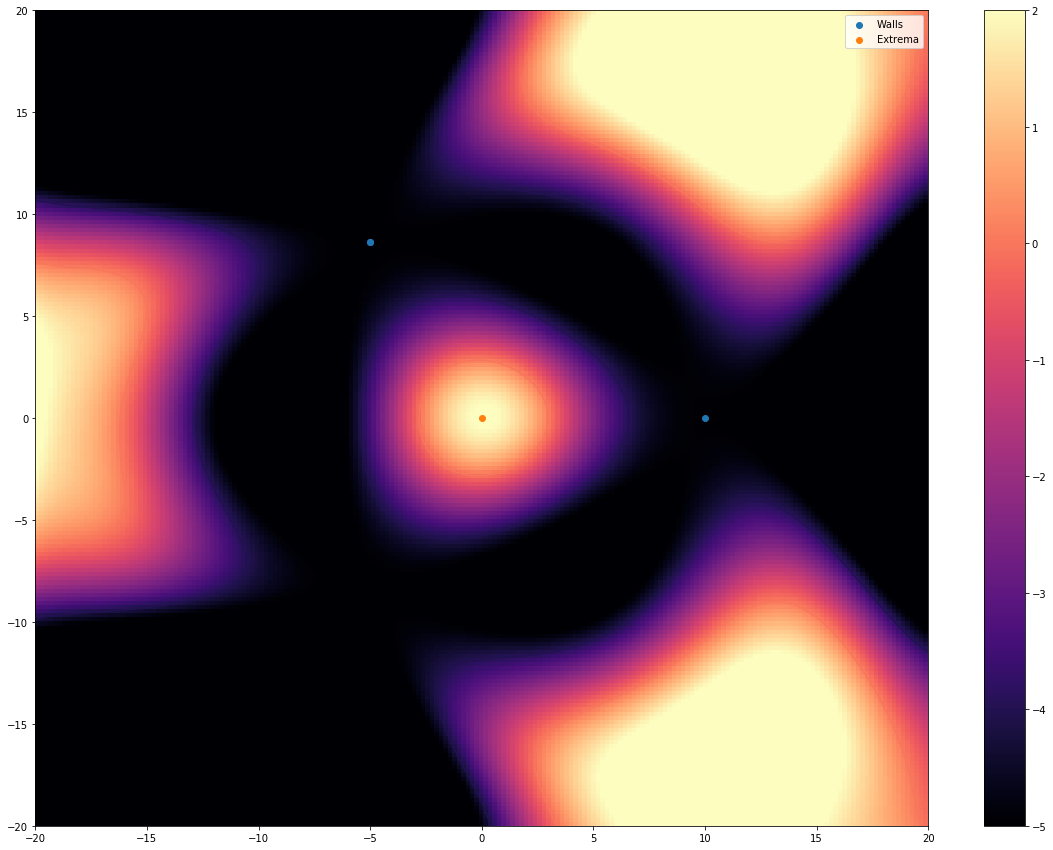

In [115]:
x = y = np.linspace(-2*D, 2*D, 200)
plt.figure(figsize=(20, 15))
kwa = dict(cmap = 'magma', vmin=V, vmax=2)
plt.contour(x, y, mean_c(x, y), **kwa)
# plt.contourf(x, y, mean_c(x, y))

plt.pcolormesh(x, y, mean_c(x, y), **kwa)
plt.colorbar()

plt.scatter(*C.positions[[0, 10, 14], :2].T, label='Walls')
plt.scatter(0, 0, label='Extrema')

plt.legend()

# Two walls on a line, only $x$ terms

In [ ]:
%run code/correlations.py
C = Correlator()
D = 15    # Mpc/h
Rwall = 5 # Mpc/h
Rfil = 5  # Mpc/h
SKIP = np.inf
KEEP = np.nan

## Wall:
# 0.14, 0.03, -1.25
## Filament:
# 0.025, -1.072, -1.505

sigmawall = sigma(0, Rwall)
nu1 = 0.5 / sigmawall
C.add_point([-D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, SKIP, SKIP], 
                hessian=[0.14, SKIP, SKIP, SKIP, SKIP, SKIP],
                #delta=[nu1]
            ),
            name='V_1') # This is wall 1

nu2 = 0.1 / sigmawall
C.add_point([+D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, SKIP, SKIP], 
                hessian=[0.14, SKIP, SKIP, SKIP, SKIP, SKIP],
                #delta=[nu2]
            ),
            name='V_2') # This is wall 2

sigmafil = sigma(0, Rfil)
nuc = 1.2 / sigmafil
C.add_point([0, 0, 0], ['delta', 'a'], Rfil, constrains=dict(
    a=[KEEP, SKIP, SKIP],
    grad_delta=[0, SKIP, SKIP], 
    hessian=[-1.505, SKIP, SKIP, SKIP, SKIP, SKIP],
    #delta=[nuc]
))

_ = C.cov_c
C.mean_c

In [55]:
C.describe_table()


| | $\delta^{V_1}$ | $\nabla_x \delta^{V_1}$ | $\nabla_y \delta^{V_1}$ | $\nabla_z \delta^{V_1}$ | $h_{xx}^{V_1}$ | $h_{yy}^{V_1}$ | $h_{zz}^{V_1}$ | $h_{xy}^{V_1}$ | $h_{xz}^{V_1}$ | $h_{yz}^{V_1}$ | $\delta^{V_2}$ | $\nabla_x \delta^{V_2}$ | $\nabla_y \delta^{V_2}$ | $\nabla_z \delta^{V_2}$ | $h_{xx}^{V_2}$ | $h_{yy}^{V_2}$ | $h_{zz}^{V_2}$ | $h_{xy}^{V_2}$ | $h_{xz}^{V_2}$ | $h_{yz}^{V_2}$ | $\delta^{3}$ | $a_x^{3}$ | $a_y^{3}$ | $a_z^{3}$ |
|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|-|
|$\delta^{V_1}$|$   1.00000$ | $          $ | $          $ | $          $ | $  -0.22669$ | $  -0.22669$ | $  -0.22669$ | $          $ | $          $ | $          $ | $   0.08736$ | $  -0.04582$ | $          $ | $          $ | $   0.01927$ | $  -0.00605$ | $  -0.00605$ | $          $ | $          $ | $          $ | $   0.39348$ | $  -0.21817$ | $          $ | $          $|
|$\nabla_x \delta^{V_1}$|$          $ | $   0.22669$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.04582$ | $  -0.01927$ | $          $ | $          $ | $   0.01401$ | $  -0.00492$ | $  -0.00492$ | $          $ | $          $ | $          $ | $   0.23680$ | $   0.00535$ | $          $ | $          $|
|$\nabla_y \delta^{V_1}$|$          $ | $          $ | $   0.22669$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.00605$ | $          $ | $          $ | $          $ | $          $ | $  -0.00492$ | $          $ | $          $ | $          $ | $          $ | $   0.08474$ | $          $|
|$\nabla_z \delta^{V_1}$|$          $ | $          $ | $          $ | $   0.22669$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.00605$ | $          $ | $          $ | $          $ | $          $ | $  -0.00492$ | $          $ | $          $ | $          $ | $          $ | $   0.08474$|
|$h_{xx}^{V_1}$|$  -0.22669$ | $          $ | $          $ | $          $ | $   0.20000$ | $   0.06667$ | $   0.06667$ | $          $ | $          $ | $          $ | $   0.01927$ | $  -0.01401$ | $          $ | $          $ | $   0.00768$ | $  -0.00315$ | $  -0.00315$ | $          $ | $          $ | $          $ | $   0.07984$ | $   0.02961$ | $          $ | $          $|
|$h_{yy}^{V_1}$|$  -0.22669$ | $          $ | $          $ | $          $ | $   0.06667$ | $   0.20000$ | $   0.06667$ | $          $ | $          $ | $          $ | $  -0.00605$ | $   0.00492$ | $          $ | $          $ | $  -0.00315$ | $   0.00195$ | $   0.00065$ | $          $ | $          $ | $          $ | $  -0.06255$ | $   0.02097$ | $          $ | $          $|
|$h_{zz}^{V_1}$|$  -0.22669$ | $          $ | $          $ | $          $ | $   0.06667$ | $   0.06667$ | $   0.20000$ | $          $ | $          $ | $          $ | $  -0.00605$ | $   0.00492$ | $          $ | $          $ | $  -0.00315$ | $   0.00065$ | $   0.00195$ | $          $ | $          $ | $          $ | $  -0.06255$ | $   0.02097$ | $          $ | $          $|
|$h_{xy}^{V_1}$|$          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $ | $          $ | $          $ | $          $ | $   0.00492$ | $          $ | $          $ | $          $ | $          $ | $  -0.00315$ | $          $ | $          $ | $          $ | $          $ | $   0.02097$ | $          $|
|$h_{xz}^{V_1}$|$          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $ | $          $ | $          $ | $          $ | $   0.00492$ | $          $ | $          $ | $          $ | $          $ | $  -0.00315$ | $          $ | $          $ | $          $ | $          $ | $   0.02097$|
|$h_{yz}^{V_1}$|$          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.00065$ | $          $ | $          $ | $          $ | $          $|
|$\delta^{V_2}$|$   0.08736$ | $   0.04582$ | $          $ | $          $ | $   0.01927$ | $  -0.00605$ | $  -0.00605$ | $          $ | $          $ | $          $ | $   1.00000$ | $          $ | $          $ | $          $ | $  -0.22669$ | $  -0.22669$ | $  -0.22669$ | $          $ | $          $ | $          $ | $   0.39348$ | $   0.21817$ | $          $ | $          $|
|$\nabla_x \delta^{V_2}$|$  -0.04582$ | $  -0.01927$ | $          $ | $          $ | $  -0.01401$ | $   0.00492$ | $   0.00492$ | $          $ | $          $ | $          $ | $          $ | $   0.22669$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $  -0.23680$ | $   0.00535$ | $          $ | $          $|
|$\nabla_y \delta^{V_2}$|$          $ | $          $ | $   0.00605$ | $          $ | $          $ | $          $ | $          $ | $   0.00492$ | $          $ | $          $ | $          $ | $          $ | $   0.22669$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.08474$ | $          $|
|$\nabla_z \delta^{V_2}$|$          $ | $          $ | $          $ | $   0.00605$ | $          $ | $          $ | $          $ | $          $ | $   0.00492$ | $          $ | $          $ | $          $ | $          $ | $   0.22669$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.08474$|
|$h_{xx}^{V_2}$|$   0.01927$ | $   0.01401$ | $          $ | $          $ | $   0.00768$ | $  -0.00315$ | $  -0.00315$ | $          $ | $          $ | $          $ | $  -0.22669$ | $          $ | $          $ | $          $ | $   0.20000$ | $   0.06667$ | $   0.06667$ | $          $ | $          $ | $          $ | $   0.07984$ | $  -0.02961$ | $          $ | $          $|
|$h_{yy}^{V_2}$|$  -0.00605$ | $  -0.00492$ | $          $ | $          $ | $  -0.00315$ | $   0.00195$ | $   0.00065$ | $          $ | $          $ | $          $ | $  -0.22669$ | $          $ | $          $ | $          $ | $   0.06667$ | $   0.20000$ | $   0.06667$ | $          $ | $          $ | $          $ | $  -0.06255$ | $  -0.02097$ | $          $ | $          $|
|$h_{zz}^{V_2}$|$  -0.00605$ | $  -0.00492$ | $          $ | $          $ | $  -0.00315$ | $   0.00065$ | $   0.00195$ | $          $ | $          $ | $          $ | $  -0.22669$ | $          $ | $          $ | $          $ | $   0.06667$ | $   0.06667$ | $   0.20000$ | $          $ | $          $ | $          $ | $  -0.06255$ | $  -0.02097$ | $          $ | $          $|
|$h_{xy}^{V_2}$|$          $ | $          $ | $  -0.00492$ | $          $ | $          $ | $          $ | $          $ | $  -0.00315$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $ | $          $ | $          $ | $          $ | $  -0.02097$ | $          $|
|$h_{xz}^{V_2}$|$          $ | $          $ | $          $ | $  -0.00492$ | $          $ | $          $ | $          $ | $          $ | $  -0.00315$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $ | $          $ | $          $ | $          $ | $  -0.02097$|
|$h_{yz}^{V_2}$|$          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.00065$ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $ | $          $ | $          $ | $          $|
|$\delta^{3}$|$   0.39348$ | $   0.23680$ | $          $ | $          $ | $   0.07984$ | $  -0.06255$ | $  -0.06255$ | $          $ | $          $ | $          $ | $   0.39348$ | $  -0.23680$ | $          $ | $          $ | $   0.07984$ | $  -0.06255$ | $  -0.06255$ | $          $ | $          $ | $          $ | $   1.00000$ | $          $ | $          $ | $          $|
|$a_x^{3}$|$  -0.21817$ | $   0.00535$ | $          $ | $          $ | $   0.02961$ | $   0.02097$ | $   0.02097$ | $          $ | $          $ | $          $ | $   0.21817$ | $   0.00535$ | $          $ | $          $ | $  -0.02961$ | $  -0.02097$ | $  -0.02097$ | $          $ | $          $ | $          $ | $          $ | $   0.33333$ | $          $ | $          $|
|$a_y^{3}$|$          $ | $          $ | $   0.08474$ | $          $ | $          $ | $          $ | $          $ | $   0.02097$ | $          $ | $          $ | $          $ | $          $ | $   0.08474$ | $          $ | $          $ | $          $ | $          $ | $  -0.02097$ | $          $ | $          $ | $          $ | $          $ | $   0.33333$ | $          $|
|$a_z^{3}$|$          $ | $          $ | $          $ | $   0.08474$ | $          $ | $          $ | $          $ | $          $ | $   0.02097$ | $          $ | $          $ | $          $ | $          $ | $   0.08474$ | $          $ | $          $ | $          $ | $          $ | $  -0.02097$ | $          $ | $          $ | $          $ | $          $ | $   0.33333$|


In [10]:
C.describe_table(constrained=True)


| | $\delta^{V_1}$ | $\delta^{V_2}$ | $\delta^{3}$ | $a_x^{3}$ |
|-|-|--|--|-|
|$\delta^{V_1}$|$   0.74068$ | $   0.05408$ | $   0.28919$ | $  -0.19943$|
|$\delta^{V_2}$|$   0.05408$ | $   0.74068$ | $   0.28919$ | $   0.19943$|
|$\delta^{3}$|$   0.28919$ | $   0.28919$ | $   0.78881$ | $          $|
|$a_x^{3}$|$  -0.19943$ | $   0.19943$ | $          $ | $   0.32879$|


In [15]:
cov_c = C.cov_c
nu0term = ((-cov_c[0, 2] * cov_c[1, 1] + cov_c[0, 0]*  cov_c[1, 2] + 
     cov_c[0, 1] * (-cov_c[0, 2] + cov_c[1, 2])) * cov_c[3, 
    0] + (-cov_c[0, 1]**2 + cov_c[0, 0] * cov_c[1, 1]) * cov_c[3, 2])
nu2term =  ((cov_c[0, 2]**2 + 
     cov_c[0, 2] * cov_c[1, 2] - (cov_c[0, 0] + cov_c[0, 1]) * cov_c[2, 
       2]) * cov_c[3, 0] + (cov_c[0, 1] * cov_c[0, 2] - cov_c[0, 0] * cov_c[1, 2]) * cov_c[3, 
    2])
nu1term = ((-cov_c[0, 2] * cov_c[1, 2] - 
     cov_c[1, 2]**2 + (cov_c[0, 1] + cov_c[1, 1]) * cov_c[2, 2]) * cov_c[3,
     0] + (-cov_c[0, 2] * cov_c[1, 1] + cov_c[0, 1] * cov_c[1, 2]) * cov_c[
    3, 2])
nu0term, nu1term, nu2term

(6.68076686765296e-18, -0.09166966450070903, 0.091669664500709)

In [16]:
%run code/correlations.py
C2 = Correlator()
D = 20    # Mpc/h
Rwall = 5 # Mpc/h
Rfil = 5  # Mpc/h
SKIP = np.inf
KEEP = np.nan

## Wall:
# 0.14, 0.03, -1.25
## Filament:
# 0.025, -1.072, -1.505
sigmawall = sigma(0, Rwall)
nu1 = 0.5 / sigmawall
C2.add_point([-D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, 0, 0], 
                hessian=[0.14, 0.03, -1.25, 0, 0, 0],
                #delta=[nu1]
            ),
            name='V_1') # This is wall 1

nu2 = 0.1 / sigmawall
C2.add_point([+D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, 0, 0], 
                hessian=[0.14, 0.03, -1.25, 0, 0, 0],
                #delta=[nu2]
            ),
            name='V_2') # This is wall 2

sigmafil = sigma(0, Rfil)
nuc = 1.2 / sigmafil
C2.add_point([0, 0, 0], ['delta', 'a'], Rfil, constrains=dict(
    a=[KEEP, SKIP, SKIP],
    grad_delta=[0, 0, 0], 
    hessian=[-1.505, -1.072, 0.025 , 0, 0, 0],
    #delta=[nuc]
))

_ = C2.cov_c
C2.mean_c

24x24: 100%|██████████| 300/300 [00:04<00:00, 67.20it/s]


array([0.76097952, 0.76097952, 0.64361383, 0.        ])

In [17]:
C2.describe_table(constrained=True)


| | $\delta^{V_1}$ | $\delta^{V_2}$ | $\delta^{3}$ | $a_x^{3}$ |
|-|-|--|--|-|
|$\delta^{V_1}$|$   0.53568$ | $   0.04164$ | $   0.22281$ | $  -0.18297$|
|$\delta^{V_2}$|$   0.04164$ | $   0.53568$ | $   0.22281$ | $   0.18297$|
|$\delta^{3}$|$   0.22281$ | $   0.22281$ | $   0.74827$ | $          $|
|$a_x^{3}$|$  -0.18297$ | $   0.18297$ | $          $ | $   0.32597$|


In [18]:
cov_c = C2.cov_c
nu0term = ((-cov_c[0, 2] * cov_c[1, 1] + cov_c[0, 0]*  cov_c[1, 2] + 
     cov_c[0, 1] * (-cov_c[0, 2] + cov_c[1, 2])) * cov_c[3, 
    0] + (-cov_c[0, 1]**2 + cov_c[0, 0] * cov_c[1, 1]) * cov_c[3, 2])
nu2term =  ((cov_c[0, 2]**2 + 
     cov_c[0, 2] * cov_c[1, 2] - (cov_c[0, 0] + cov_c[0, 1]) * cov_c[2, 
       2]) * cov_c[3, 0] + (cov_c[0, 1] * cov_c[0, 2] - cov_c[0, 0] * cov_c[1, 2]) * cov_c[3, 
    2])
nu1term = ((-cov_c[0, 2] * cov_c[1, 2] - 
     cov_c[1, 2]**2 + (cov_c[0, 1] + cov_c[1, 1]) * cov_c[2, 2]) * cov_c[3,
     0] + (-cov_c[0, 2] * cov_c[1, 1] + cov_c[0, 1] * cov_c[1, 2]) * cov_c[
    3, 2])
nu0term, nu1term, nu2term

(-1.2144194386415563e-17, -0.060876741043753166, 0.060876741043753194)

# Two walls on a line

In [48]:
%run code/correlations.py
C = Correlator()
D = 20    # Mpc/h
Rwall = 5 # Mpc/h
Rfil = 5  # Mpc/h
cons = dict(
    grad_delta=[0, 0, 0], 
    hessian=[np.nan, np.nan, np.nan, 0, 0, 0])

sigmawall = sigma(0, Rwall)
nu1 = 0.5 / sigmawall
cons.update(delta=[ nu1])
C.add_point([-D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=cons,
            name='V_1') # This is wall 1

nu2 = 0.1 / sigmawall
cons.update(delta=[ nu2])
C.add_point([+D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=cons,
            name='V_2') # This is wall 2

sigmafil = sigma(0, Rfil)
nuc = 1.2 / sigmafil
ptCons = cons.copy()
ptCons['delta'] = [nuc]
C.add_point([0, 0, 0], ['delta'], Rfil, constrains=ptCons)

Npt = 8
pos = np.linspace(-D, D, Npt+1, endpoint=False)[1:]
if 0 in pos:
    print('Running into problems, you have twice the same point.')

for x in pos:
    ptCons = cons.copy()
    C.add_point([x, 0, 0], ['delta'], Rfil)
_ = C.cov

29x29: 100%|██████████| 435/435 [00:13<00:00, 31.69it/s]

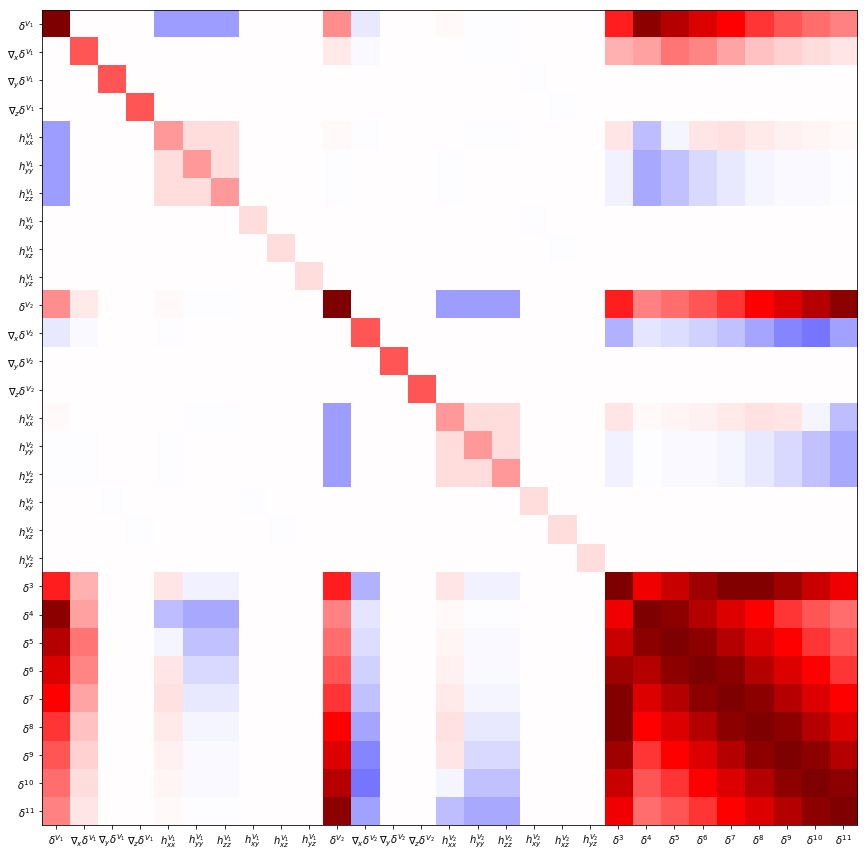

In [45]:
plt.figure(figsize=(15, 15))
C.plot_cov()

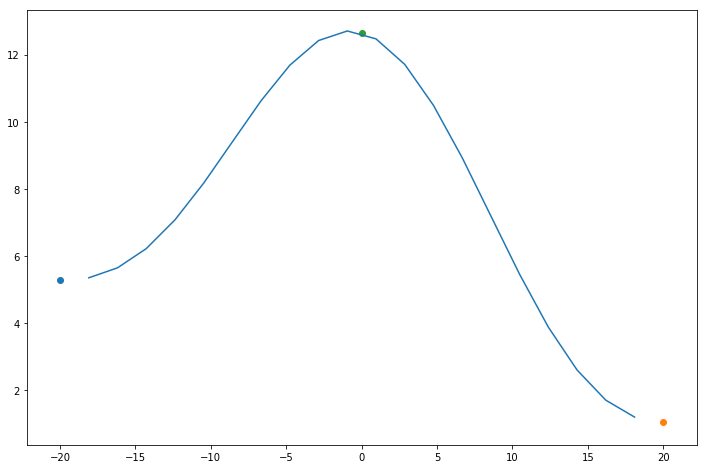

In [37]:
plt.plot(pos, C.mean_c[-Npt:])
plt.scatter(-D, nu1)
plt.scatter(D, nu2)
plt.scatter(0, nuf)

# Debugging

In [55]:
%run code/correlations.py
C = Correlator()
D = 0.5    # Mpc/h
Rwall = 5 # Mpc/h
Rfil = 5  # Mpc/h

C.add_point([0, 0, 0], ['a'], Rfil)
C.add_point([D, 0, 0], ['hessian'], Rwall) 
_ = C.cov

9x9: 100%|██████████| 45/45 [00:00<00:00, 45.39it/s]


In [56]:
from IPython.display import display, Markdown 
#order = [0, 4,5,6, 1,2,3, 7,8,9, 10, 14,15,16, 11,12,13, 17,18,19]
display(Markdown(C.describe_table()))


| | $a_x^{1}$ | $a_y^{1}$ | $a_z^{1}$ | $h_{xx}^{2}$ | $h_{yy}^{2}$ | $h_{zz}^{2}$ | $h_{xy}^{2}$ | $h_{xz}^{2}$ | $h_{yz}^{2}$ |
|-|-|--|--|--|--|--|--|--|-|
|$a_x^{1}$|$   0.33333$ | $          $ | $          $ | $  -0.00518$ | $  -0.00173$ | $  -0.00173$ | $          $ | $          $ | $          $|
|$a_y^{1}$|$          $ | $   0.33333$ | $          $ | $          $ | $          $ | $          $ | $  -0.00173$ | $          $ | $          $|
|$a_z^{1}$|$          $ | $          $ | $   0.33333$ | $          $ | $          $ | $          $ | $          $ | $  -0.00173$ | $          $|
|$h_{xx}^{2}$|$  -0.00518$ | $          $ | $          $ | $   0.20000$ | $   0.06667$ | $   0.06667$ | $          $ | $          $ | $          $|
|$h_{yy}^{2}$|$  -0.00173$ | $          $ | $          $ | $   0.06667$ | $   0.20000$ | $   0.06667$ | $          $ | $          $ | $          $|
|$h_{zz}^{2}$|$  -0.00173$ | $          $ | $          $ | $   0.06667$ | $   0.06667$ | $   0.20000$ | $          $ | $          $ | $          $|
|$h_{xy}^{2}$|$          $ | $  -0.00173$ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $ | $          $|
|$h_{xz}^{2}$|$          $ | $          $ | $  -0.00173$ | $          $ | $          $ | $          $ | $          $ | $   0.06667$ | $          $|
|$h_{yz}^{2}$|$          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $          $ | $   0.06667$|


<IPython.core.display.Markdown object>

<IPython.core.display.Javascript object>


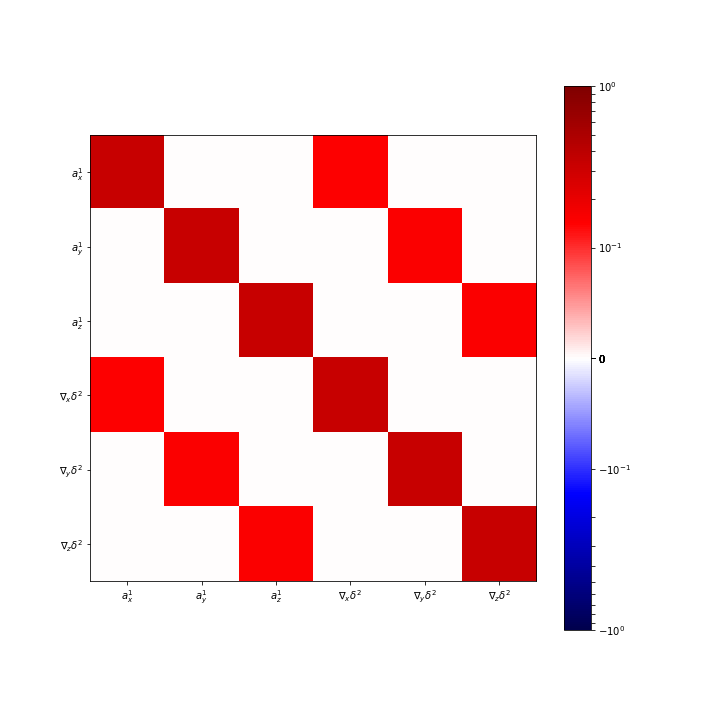

In [40]:
%matplotlib nbagg
import matplotlib as mpl
plt.figure(figsize=(10, 10))
C.plot_cov(symlog=True)
plt.colorbar()

In [38]:
np.round(C.cov[4:10,14:20], 6), np.round(C.cov[4:10,14:20]*3, 6), 

(array([[0.198197, 0.066306, 0.066306, 0.      , 0.      , 0.      ],
        [0.066306, 0.199639, 0.066546, 0.      , 0.      , 0.      ],
        [0.066306, 0.066546, 0.199639, 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.066306, 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.066306, 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.066546]]),
 array([[0.594591, 0.198918, 0.198918, 0.      , 0.      , 0.      ],
        [0.198918, 0.598917, 0.199639, 0.      , 0.      , 0.      ],
        [0.198918, 0.199639, 0.598917, 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.198918, 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.198918, 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.199639]]))

# Distribution for walls, filaments, peaks

In [443]:
%run code/correlations.py
C = Correlator()
R = 5
C.add_point([0, 0, 0], ['density', 'grad_delta', 'hessian'], R, constrains={
    'grad_delta': [0, 0, 0],
    'hessian': [np.nan, np.nan, np.nan, 0, 0, 0],
}, name='')
mean, cov = C.mean_c, C.cov_c
display(Markdown('  '.join(C.labels_c)))

10x10: 100%|██████████| 55/55 [00:00<00:00, 62.43it/s]


$\delta^{}$  $h_{xx}^{}$  $h_{yy}^{}$  $h_{zz}^{}$

In [444]:
@jit(nopython=True)
def logprob(X, mean, icov, s1, s2, s3):
    h = X[-3:]
    diff = X-mean
    
    if not (s1*h[0] > 0 and s2*h[1] > 0 and s3*h[2] > 0):
        return -np.inf
    
    # Impose order of eigenvalues
    if not (h[0] > h[1] > h[2]):
        return -np.inf
    logdet = np.log(np.abs(h[0]*h[1]*h[2]))
    ret = -1/2 * np.dot(diff, np.dot(icov, diff)) + logdet
    return ret

ndim = len(C.mean_c)
nwalkers = 2*ndim
nburn = int(1e3)
ndraw = int(1e5)
icov = np.linalg.inv(cov)

def plot(sample, labels=None):
    a, b = np.percentile(sample, [.1, 99.9])
    kwa = dict(
        bins = np.linspace(a, b, 100),
        histtype = 'step'
    )
    labels = labels if labels else C.labels_c
    for i in range(sample.shape[1]):
        H, bins, patches = plt.hist(sample[:, i], **kwa, label=labels[i], normed=True)
        med = np.median(sample[:, i])
        color = patches[0].get_facecolor()[:-1]
        
        l, m, r = np.percentile(sample[:, i], [1, 50, 99])

        plt.axvline(med, ls='--', c=color)
        #plt.axvline(l, ls=':', c=color)
        #plt.axvline(r, ls=':', c=color)

    plt.xlabel('Value')
    plt.ylabel('p(x)')
    plt.legend()

## Filament

Burn run

In [445]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=[mean, icov, 1, -1, -1])
p00 = [np.array((1.2, 1, -1, -2)) + (np.random.rand(4)-0.5) for _ in range(nwalkers)]
# Burn run
pos, prob, state = sampler.run_mcmc(p00, nburn)
sampler.reset()

Draw using MCMC

In [446]:
sampler.reset()
sampler.run_mcmc(pos, ndraw // nwalkers)
sample = sampler.flatchain

array([[ 0.41372705,  0.39119156, -0.34767626, -0.63387275],
       [ 1.25700456,  0.64017809, -0.17305172, -0.40614316]])

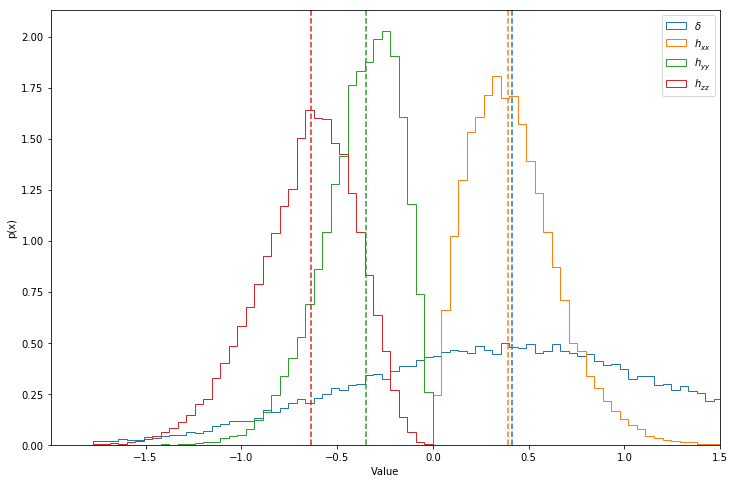

In [449]:
plot(sample)
plt.xlim(xmax=1.5)
np.percentile(sample, [50, 68/2+50], axis=0)

### Filament at $\nu=1.2$ (~$1\sigma$)

In [450]:
nufil = 1.2
mmean, ccov = constrain(mean, cov, np.array([nufil, np.nan, np.nan, np.nan]))
iccov = np.linalg.inv(ccov)
                       
nw = 10
sampler = emcee.EnsembleSampler(nw, 3, logprob, args=[mmean, iccov, 1, -1, -1])
p00 = [np.array((1.5, -1, -2)) + (np.random.rand(3)-0.5) for _ in range(nw)]
# Burn run
pos, prob, state = sampler.run_mcmc(p00, nburn)
sampler.reset()

Draw using MCMC

In [451]:
sampler.reset()
sampler.run_mcmc(pos, 10 * ndraw // nw)
sample = sampler.flatchain

array([ 0.025, -1.072, -1.505])

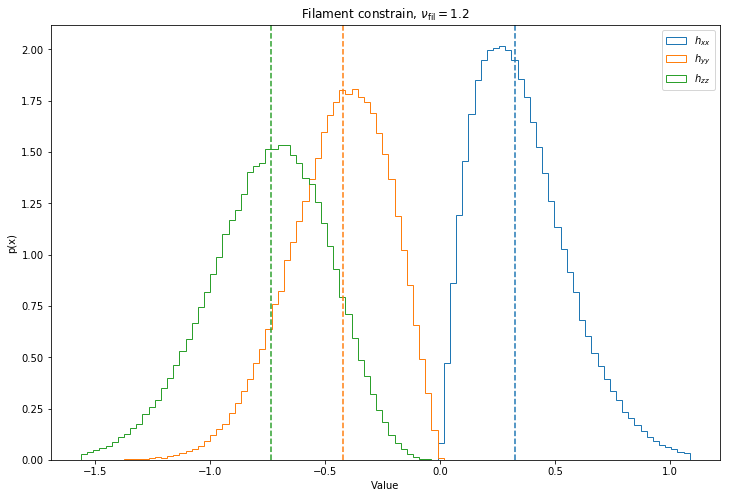

In [455]:
plot(sample, ['$h_{xx}$', '$h_{yy}$', '$h_{zz}$'])
plt.title(r'Filament constrain, $\nu_\mathrm{fil} = %s$' % nufil)
plt.savefig('plots/filament_nu=%.2f.pdf' % nufil)
np.round(np.percentile(sample, 0.5, axis=0), 3)

## Wall

Burn run

In [378]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=[mean, icov, 1, 1, -1])
p00 = [np.array((1.2, 1.5, 1, -2)) + (np.random.rand(4)-0.5) for _ in range(nwalkers)]
# Burn run
pos, prob, state = sampler.run_mcmc(p00, nburn)
sampler.reset()

Draw using MCMC

In [379]:
sampler.reset()
sampler.run_mcmc(pos, ndraw // nwalkers)
sample = sampler.flatchain

array([[-0.41620816,  0.63975006,  0.34949285, -0.38842924],
       [ 0.38443968,  0.92604465,  0.56173702, -0.18360659]])

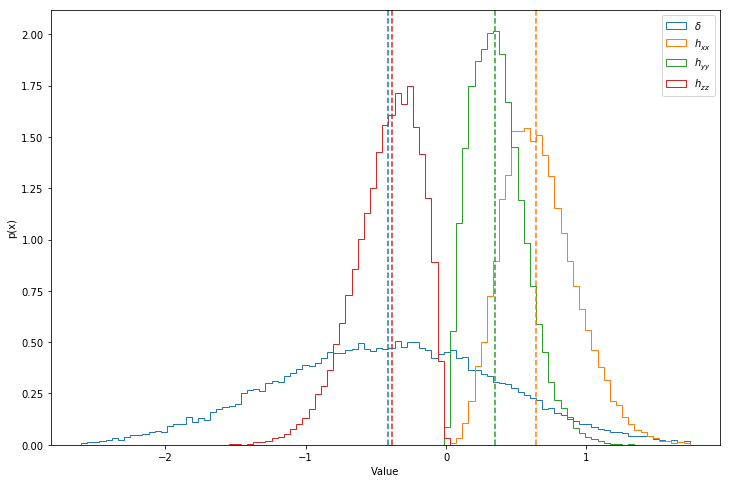

In [381]:
plot(sample)
np.percentile(sample, [50, 68/2+50], axis=0)

### Wall at $\nu=0.40$ (~$1\sigma$)

In [429]:
nuwall = 0.40
mmean, ccov = constrain(mean, cov, np.array([nuwall, np.nan, np.nan, np.nan]))
iccov = np.linalg.inv(ccov)
                       
nw = 10
sampler = emcee.EnsembleSampler(nw, 3, logprob, args=[mmean, iccov, 1, 1, -1])
p00 = [np.array((1.5, 1, -2)) + (np.random.rand(3)-0.5) for _ in range(nw)]
# Burn run
pos, prob, state = sampler.run_mcmc(p00, nburn)
sampler.reset()

/home/ccc/.anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/ccc/.anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Draw using MCMC

In [430]:
sampler.reset()
sampler.run_mcmc(pos, 10 * ndraw // nw)
sample = sampler.flatchain

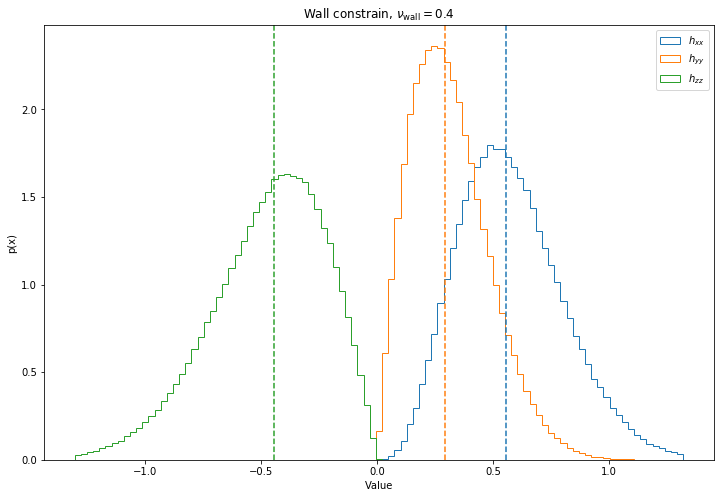

In [431]:
plot(sample, ['$h_{xx}$', '$h_{yy}$', '$h_{zz}$'])
np.round(np.percentile(sample, 0.5, axis=0), 3)
plt.title(r'Wall constrain, $\nu_\mathrm{wall} = %s$' % nuwall)
plt.savefig('plots/wall_nu=%.2f.pdf' % nuwall)

### Wall at $\nu=0.0$ (~$0.5\sigma$)

In [432]:
nuwall = 0.0
mmean, ccov = constrain(mean, cov, np.array([nuwall, np.nan, np.nan, np.nan]))
iccov = np.linalg.inv(ccov)
                       
nw = 10
sampler = emcee.EnsembleSampler(nw, 3, logprob, args=[mmean, iccov, 1, 1, -1])
p00 = [np.array((1.5, 1, -2)) + (np.random.rand(3)-0.5) for _ in range(nw)]
# Burn run
pos, prob, state = sampler.run_mcmc(p00, nburn)
sampler.reset()

Draw using MCMC

In [433]:
sampler.reset()
sampler.run_mcmc(pos, 10*ndraw // nw)
sample = sampler.flatchain

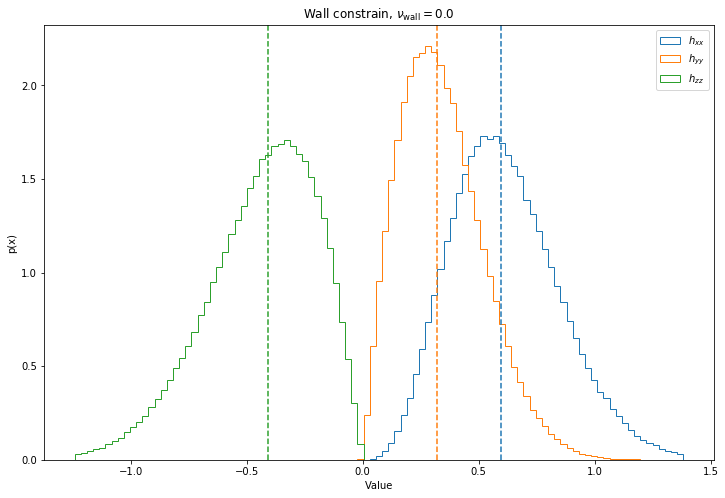

In [434]:
plot(sample, ['$h_{xx}$', '$h_{yy}$', '$h_{zz}$'])
np.round(np.percentile(sample, 0.5, axis=0), 3)
plt.title(r'Wall constrain, $\nu_\mathrm{wall} = %s$' % nuwall)
plt.savefig('plots/wall_nu=%.2f.pdf' % nuwall)

## Void

Burn run

In [362]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=[mean, icov, 1, 1, 1])
p00 = [np.array((1.2, 2, 1, 0.5)) + (np.random.rand(4)-0.5) for _ in range(nwalkers)]
# Burn run
pos, prob, state = sampler.run_mcmc(p00, nburn)
sampler.reset()

/home/ccc/.anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/ccc/.anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Draw using MCMC

In [363]:
sampler.reset()
sampler.run_mcmc(pos, ndraw // nwalkers)
sample = sampler.flatchain

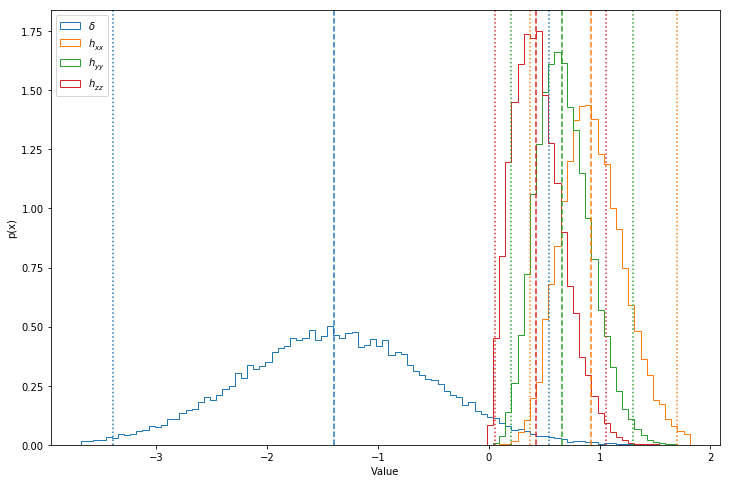

In [364]:
plot(sample)

# Two walls on a line

In [216]:
%run code/correlations.py
C = Correlator()
N = 10
D = 10    # Mpc/h
Rwall = 5 # Mpc/h
Rfil = 5  # Mpc/h
Rpt = 1  

x = np.linspace(-D, D, N+2)[1:-1]

# Two walls
nu1 = -1
C.add_point([-D, 0, 0], ['density', 'grad_delta', 'hessian'], Rwall, constrains={
    'grad_delta': [0, 0, 0],
    'hessian': [np.nan, np.nan, np.nan, 0, 0, 0],
    'density': [nu1]}
)
nu2 = -2
C.add_point([ D, 0, 0], ['density', 'grad_delta', 'hessian'], Rwall, constrains={
    'grad_delta': [0, 0, 0],
    'hessian': [np.nan, np.nan, np.nan, 0, 0, 0],
    'density': [nu2]}
) 

# One filament
nu3 = 1.2
C.add_point([0, 0, 0], ['grad_delta', 'hessian', 'density'], Rfil, constrains={
    'grad_delta': [0, 0, 0],
    'hessian': [np.nan, np.nan, np.nan, 0, 0, 0],
    'density': [nu3]
})
# Add the points
for _x in x:
    if _x == 0:
        continue
    C.add_point([_x, 0, 0], ['density'], Rpt)

In [217]:
_ = C.cov

40x40: 100%|██████████| 820/820 [00:11<00:00, 69.60it/s]

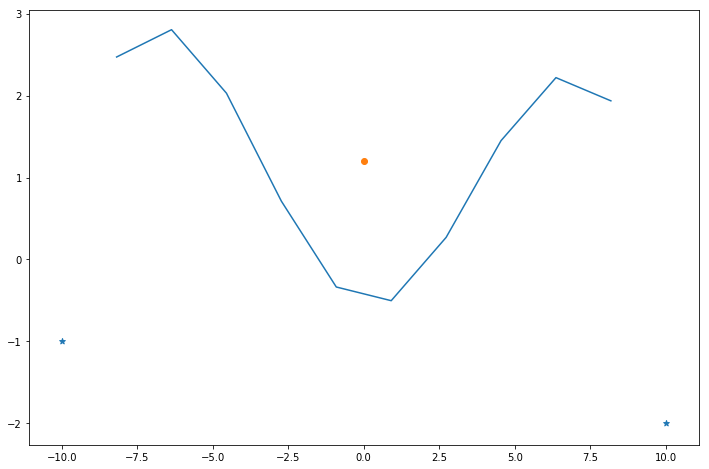

In [219]:
plt.plot(x, C.mean_c[-N:])
plt.scatter([-D, D], [nu1, nu2], marker='*')
plt.scatter(0, nu3, marker='o')

# Two walls, one peak

In [49]:
%run code/correlations.py
C = Correlator()
D = 15     # Mpc/h
Rwall = 7.5# Mpc/h
Rfil = 5   # Mpc/h
cons = dict(
    grad_delta=[0, 0, 0], 
    hessian=[0.14, 0.03, -1.25, 0, 0, 0])

sigmawall = sigma(0, Rwall)
cons.update(delta=[ 0.5 / sigmawall])
C.add_point([-D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall, 
            constrains=dict(
                grad_delta=[0, 0, 0], 
                hessian=[0.14, 0.03, -1.25, 0, 0, 0]),
           name='A_1') # This is wall 1

cons.update(delta=[ 0. / sigmawall])
C.add_point([+D, 0, 0], ['delta', 'grad_delta', 'hessian'], Rwall,
            constrains=dict(
                grad_delta=[0, 0, 0], 
                hessian=[0.14, 0.03, -1.25, 0, 0, 0]),
            name='A_2') # This is wall 2


C.add_point([0, 0, 0], ['delta', 'a', 'grad_delta', 'hessian'], Rfil,
           constrains=dict(
               a=[np.nan, np.inf, np.inf], # Forget a_y, a_z
               # delta=[1.2],
               grad_delta=[0, 0, 0],
               hessian=[0.025, -1.072, -1.505, 0, 0, 0]),
           name='A_3')

In [50]:
np.linalg.eigvalsh(C.cov), np.linalg.eigvalsh(C.cov_c)

33x33: 100%|██████████| 561/561 [00:16<00:00, 33.54it/s]

(array([-0.02521507,  0.00785045,  0.00785045,  0.01258271,  0.03992434,
         0.05037493,  0.05037494,  0.05469976,  0.06197047,  0.07566282,
         0.07566283,  0.07986904,  0.08821105,  0.09188566,  0.09188566,
         0.09810519,  0.1188901 ,  0.12389663,  0.13605428,  0.17433321,
         0.17433321,  0.18943368,  0.19623433,  0.22104465,  0.24269121,
         0.24269121,  0.2477826 ,  0.25168408,  0.58541569,  0.58541569,
         0.78232515,  1.34851855,  2.00220243]),
 array([-0.15612808,  0.03065286,  0.15653261,  0.98412221]))

In [51]:
C.describe_table(constrained=True)


| | $\delta^{A_1}$ | $\delta^{A_2}$ | $\delta^{A_3}$ | $a_x^{A_3}$ |
|-|-|--|--|-|
|$\delta^{A_1}$|$   0.23858$ | $   0.38413$ | $   0.32709$ | $   0.03997$|
|$\delta^{A_2}$|$   0.38413$ | $   0.23858$ | $   0.32709$ | $  -0.03997$|
|$\delta^{A_3}$|$   0.32709$ | $   0.32709$ | $   0.39206$ | $          $|
|$a_x^{A_3}$|$   0.03997$ | $  -0.03997$ | $          $ | $   0.14596$|


In [52]:
cov_c = C.cov_c
nu0term = ((-cov_c[0, 2] * cov_c[1, 1] + cov_c[0, 0]*  cov_c[1, 2] + 
     cov_c[0, 1] * (-cov_c[0, 2] + cov_c[1, 2])) * cov_c[3, 
    0] + (-cov_c[0, 1]**2 + cov_c[0, 0] * cov_c[1, 1]) * cov_c[3, 2])
nu2term =  ((cov_c[0, 2]**2 + 
     cov_c[0, 2] * cov_c[1, 2] - (cov_c[0, 0] + cov_c[0, 1]) * cov_c[2, 
       2]) * cov_c[3, 0] + (cov_c[0, 1] * cov_c[0, 2] - cov_c[0, 0] * cov_c[1, 2]) * cov_c[3, 
    2])
nu1term = ((-cov_c[0, 2] * cov_c[1, 2] - 
     cov_c[1, 2]**2 + (cov_c[0, 1] + cov_c[1, 1]) * cov_c[2, 2]) * cov_c[3,
     0] + (-cov_c[0, 2] * cov_c[1, 1] + cov_c[0, 1] * cov_c[1, 2]) * cov_c[
    3, 2])
nu0term, nu1term, nu2term

(-2.5054390268066953e-19, 0.0012056225351116732, -0.0012056225351116717)

## Dependance in $\nu_1$, $\nu_2$

In [466]:
N, M = 100, 101
nuextr = 3
nu1 = np.linspace(-nuextr, nuextr, N)# / sigma(0, Rwall)
nu2 = np.linspace(-nuextr, nuextr, M)# / sigma(0, Rwall)
a_x = np.zeros((N, M)) * np.nan
inu1 = 0
inu2 = 1
iax = 2
for i in range(N):
    for j in range(M):
        C.constrains[inu1] = nu1[i]
        C.constrains[inu2] = nu2[j]
        if nu2[j] > nu1[i]:
            continue
        a_x[i, j] = C.mean_c[6]

IndexError: index 6 is out of bounds for axis 0 with size 2

/home/ccc/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


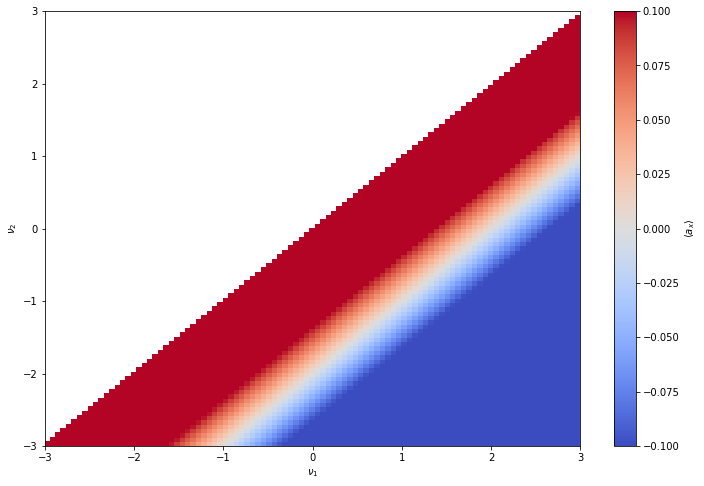

In [137]:
a = np.abs(a_x).max()
plt.pcolormesh(nu1, nu2, a_x.T, cmap='coolwarm', vmin=-a, vmax=a)
plt.xlabel(r'$\nu_1$')
plt.ylabel(r'$\nu_2$')
CM = plt.colorbar()
CM.set_label(r'$\langle a_x\rangle$')

## Export to Mathematica

In [7]:
from IPython.display import display, Math, Latex, Markdown
fmt = '''
|%(count)s|
|%(sep)s|
|%(header)s| 
|%(nick)s| 
''' % dict(
    header='|'.join(C.labels),
    sep='-|-' * len(C.labels),
    count='|'.join(('%s' % (i + 1) for i in range(len(C.labels)))),
    nick='|'.join((r'$\alpha%s$' % (i + 1) for i in range(len(C.labels))))
)

display(Markdown(fmt))


|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|
|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|-|
|$\delta^{V_1}$|$\nabla_x \delta^{V_1}$|$\nabla_y \delta^{V_1}$|$\nabla_z \delta^{V_1}$|$h_{xx}^{V_1}$|$h_{yy}^{V_1}$|$h_{zz}^{V_1}$|$h_{xy}^{V_1}$|$h_{xz}^{V_1}$|$h_{yz}^{V_1}$|$\delta^{V_2}$|$\nabla_x \delta^{V_2}$|$\nabla_y \delta^{V_2}$|$\nabla_z \delta^{V_2}$|$h_{xx}^{V_2}$|$h_{yy}^{V_2}$|$h_{zz}^{V_2}$|$h_{xy}^{V_2}$|$h_{xz}^{V_2}$|$h_{yz}^{V_2}$|$a_x^{3}$|$a_y^{3}$|$a_z^{3}$|$\delta^{3}$|$\nabla_x \delta^{3}$|$\nabla_y \delta^{3}$|$\nabla_z \delta^{3}$|$h_{xx}^{3}$|$h_{yy}^{3}$|$h_{zz}^{3}$|$h_{xy}^{3}$|$h_{xz}^{3}$|$h_{yz}^{3}$| 
|$\alpha1$|$\alpha2$|$\alpha3$|$\alpha4$|$\alpha5$|$\alpha6$|$\alpha7$|$\alpha8$|$\alpha9$|$\alpha10$|$\alpha11$|$\alpha12$|$\alpha13$|$\alpha14$|$\alpha15$|$\alpha16$|$\alpha17$|$\alpha18$|$\alpha19$|$\alpha20$|$\alpha21$|$\alpha22$|$\alpha23$|$\alpha24$|$\alpha25$|$\alpha26$|$\alpha27$|$\alpha28$|$\alpha29$|$\alpha30$|$\alpha31$|$\alpha32$|$\alpha33$| 


Build a matrix of elements compatible to a direct import in mathematica

In [60]:
ndigit = 8
chars = ['a%s' % i for i in range(100)]
mapping = {c: chars[i] for i, c in enumerate(np.unique(np.round(np.abs(C.cov), ndigit)))
          if c > 0 }

@np.vectorize
def myKey(i, j):
    a = C.cov[int(i), int(j)]
    aa = np.round(np.abs(a), ndigit)
    sign = '' if aa * a > 0 else '-'
    if aa == 0:
        return '0'
    return sign + mapping[aa]
    

coeffs = np.fromfunction(lambda i, j: myKey(i, j), C.cov.shape)
ll = []
for i in range(coeffs.shape[0]):
    l = []
    for j in range(coeffs.shape[1]):
        l.append('%5s' % coeffs[i, j])
    ll.append('{%s}' % (','.join(l)))
print('{%s}'% (',\n'.join(ll)))

{{  a38,    0,    0,    0,  a35,  a35,  a35,    0,    0,    0,  a25, -a19,    0,    0, -a14,   a8,   a8,    0,    0,    0,  a34,    0,    0,  a36, -a31,    0,    0, -a28,  a23,  a23,    0,    0,    0},
{    0,  a37,    0,    0,    0,    0,    0,    0,    0,    0, -a19, -a15,    0,    0,  a11,  -a7,  -a6,    0,    0,    0,  a21,    0,    0, -a31, -a30,    0,    0,  a24, -a22, -a22,    0,    0,    0},
{    0,    0,  a37,    0,    0,    0,    0,    0,    0,    0,    0,    0,  a10,    0,    0,    0,    0,  -a7,    0,    0,    0, -a27,    0,    0,    0,  a26,    0,    0,    0,    0, -a22,    0,    0},
{    0,    0,    0,  a37,    0,    0,    0,    0,    0,    0,    0,    0,    0,  a10,    0,    0,    0,    0,  -a6,    0,    0,    0, -a27,    0,    0,    0,  a26,    0,    0,    0,    0, -a22,    0},
{  a35,    0,    0,    0,  a33,  a29,  a29,    0,    0,    0, -a14,  a11,    0,    0,   a9,  -a4,  -a5,    0,    0,    0,  a16,    0,    0, -a28,  a24,    0,    0, -a13, -a20, -a20,    0,    0,  

## Plot of the covariance

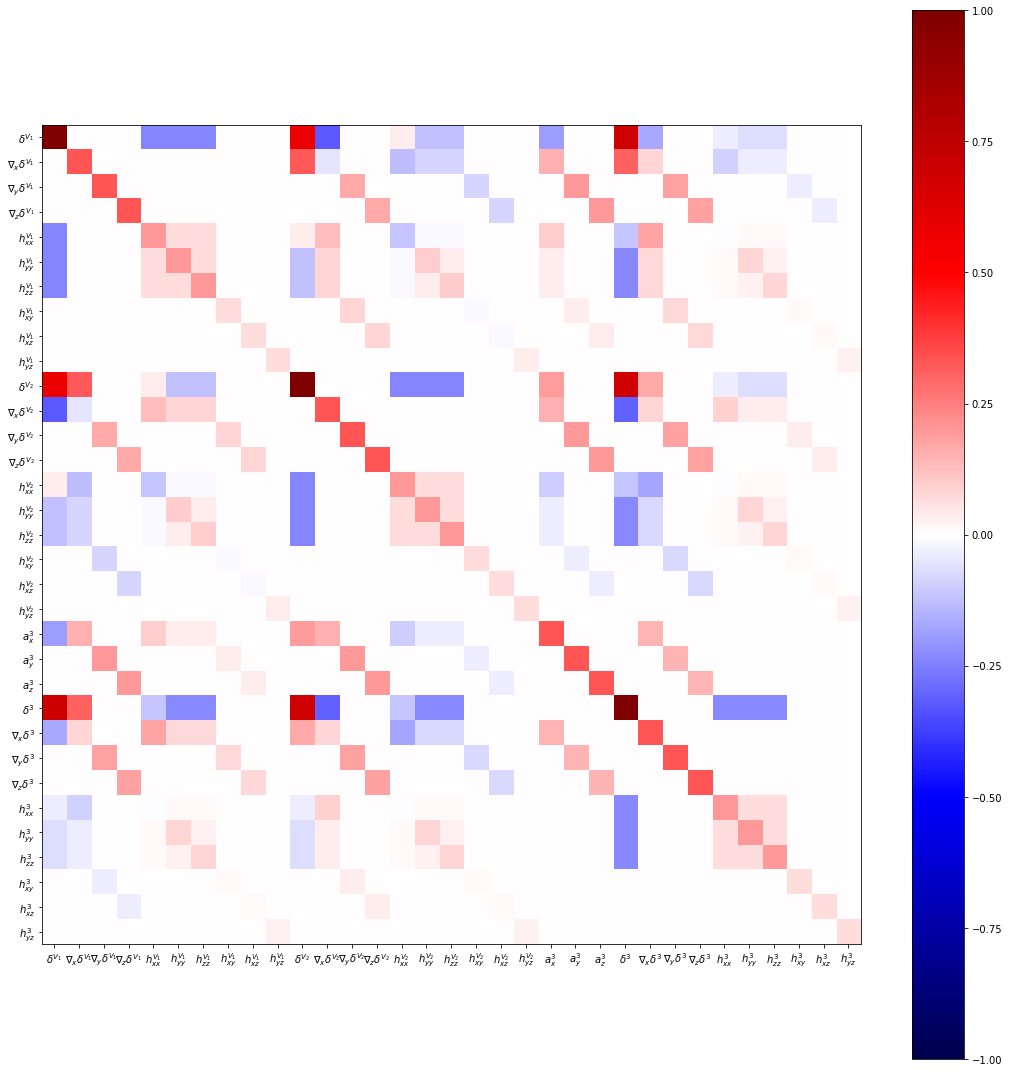

In [61]:
plt.figure(figsize=(15, 15))
C.plot_cov()
plt.colorbar()

np.linalg.eigvalsh(C.cov)
plt.tight_layout()
plt.savefig('/tmp/test.pdf')

/home/ccc/.anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/home/ccc/.anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


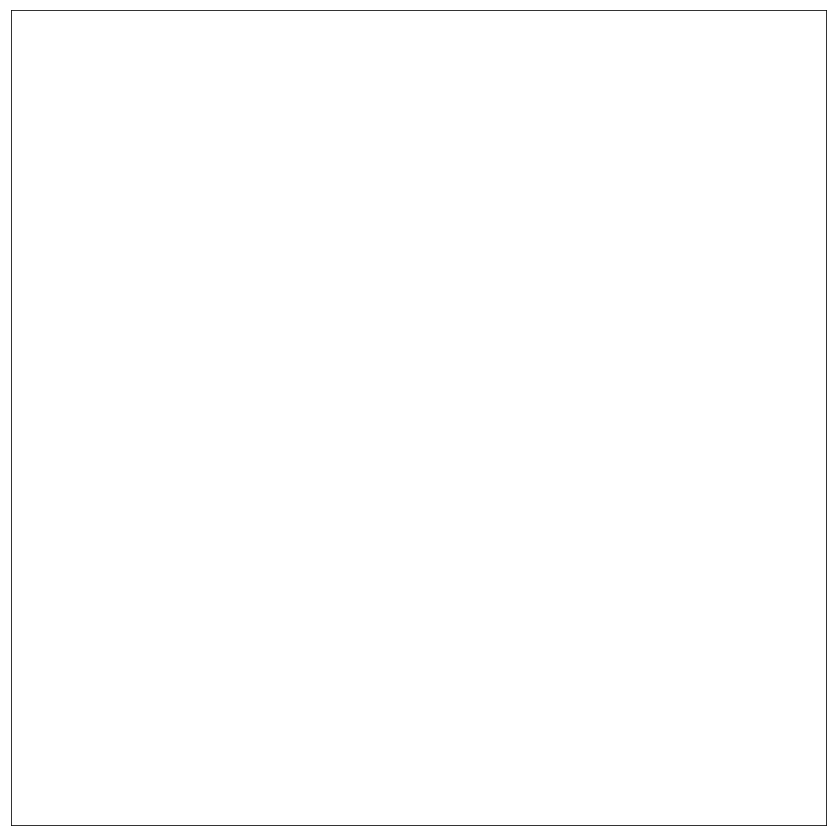

In [62]:
plt.figure(figsize=(15, 15))
C.plot_cov_c()

## Draw using MCMC

In [25]:
import emcee
from numba import jit

@jit(nopython=True, nogil=True)
def logprob(X, mu, icov):
    h1 = X[:3]
    h2 = X[3:6]
    h3 = X[7:10]

    ix, iy, iz = 0, 1, 2
    
    diff = X-mu

    # print(h1, h2, h3)
    if not (h1[ix] > 0 and h1[iy] > 0 and h1[iz] < 0):
        return -np.inf
    if not (h2[ix] > 0 and h2[iy] > 0 and h2[iz] < 0):
        return -np.inf
    if not (h3[ix] < 0 and h3[iy] > 0 and h3[iz] < 0):
        return -np.inf
    h11 = h1[0]*h1[1]*h1[2]
    h22 = h2[0]*h2[1]*h2[2]
    h33 = h3[0]*h3[1]*h3[2]
    logdet = np.log(np.abs(h11*h22*h33))
    ret = -1/2 * np.dot(diff, np.dot(icov, diff)) + logdet
    return ret
    
cov0, mean0 = C.cov_c, C.mean_c

indexes = [i for i in range(len(mean0)) if i not in [7, 8]]

# Set the height
nuf = C.constrains[23] = 1.2 / sigma(0, Rfil)
nu1 = C.constrains[0] = 0.5 / sigma(0, Rwall)
nu2 = C.constrains[10] = 0.25 / sigma(0, Rwall) 
cov, mean = C.cov_c[indexes][:, indexes], C.mean_c[indexes]
# Drop a_y, a_z
icov = np.linalg.inv(cov)
ndim = len(cov)
nwalkers = ndim*3
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=(mean, icov))
p0 = np.array([
    0.1, 0.1, -0.1, # wall 1 hessian
    0.1, 0.1, -0.1, # wall 2 hessian
    -0.5, # a_x
    -0.1, 0.1, -0.1 # saddle hessian
])

p00 = [p0 * 2 * np.random.rand(len(p0)) for _ in range(nwalkers)]
# p00 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
logprob(p0, mean, icov)

-273.2435716278071

In [19]:
pos, prob, state = sampler.run_mcmc(p00, 10000)
sampler.reset()
pos

array([[ 5.37778461,  1.16305057, -0.44745283,  9.80713749,  1.99742643,
        -0.15761735,  4.52309687, -4.97487907,  1.10100864, -1.10225762],
       [ 5.36470477,  1.10050401, -0.66513797,  9.79996373,  1.30857642,
        -0.30632216,  4.59147212, -4.97803829,  0.61635734, -1.25603518],
       [ 5.35642285,  1.28554527, -0.92756838,  9.7935448 ,  1.41173554,
        -0.177689  ,  4.36452914, -4.97984681,  0.82209507, -1.36329916],
       [ 5.37377087,  1.18119456, -0.31337857,  9.80184894,  2.4694188 ,
        -0.29245599,  3.74416819, -4.97611973,  1.26328178, -1.02412531],
       [ 5.37412847,  0.63283382, -0.40613988,  9.80581269,  1.28322482,
        -0.20135035,  4.09018551, -4.97549969,  0.39418801, -1.09344559],
       [ 5.36496164,  0.86758531, -0.86305307,  9.80060383,  1.24929717,
        -0.30966431,  3.19717917, -4.97735862,  0.36661208, -1.45037111],
       [ 5.36009982,  0.29030451, -1.09766837,  9.80422943,  1.80941682,
        -0.08191969,  4.68381037, -4.97754172

In [26]:
sampler.reset()
sampler.run_mcmc(pos, 100000)
sample = sampler.flatchain
print(sampler.acceptance_fraction)

[0.3923  0.39052 0.38938 0.3894  0.39557 0.3893  0.39184 0.39458 0.39283
 0.39037 0.39217 0.38917 0.39197 0.39222 0.39044 0.38845 0.39038 0.39214
 0.39033 0.39159 0.38952 0.39287 0.39184 0.39364 0.39325 0.39056 0.39327
 0.38939 0.39138 0.39296]


<IPython.core.display.Javascript object>


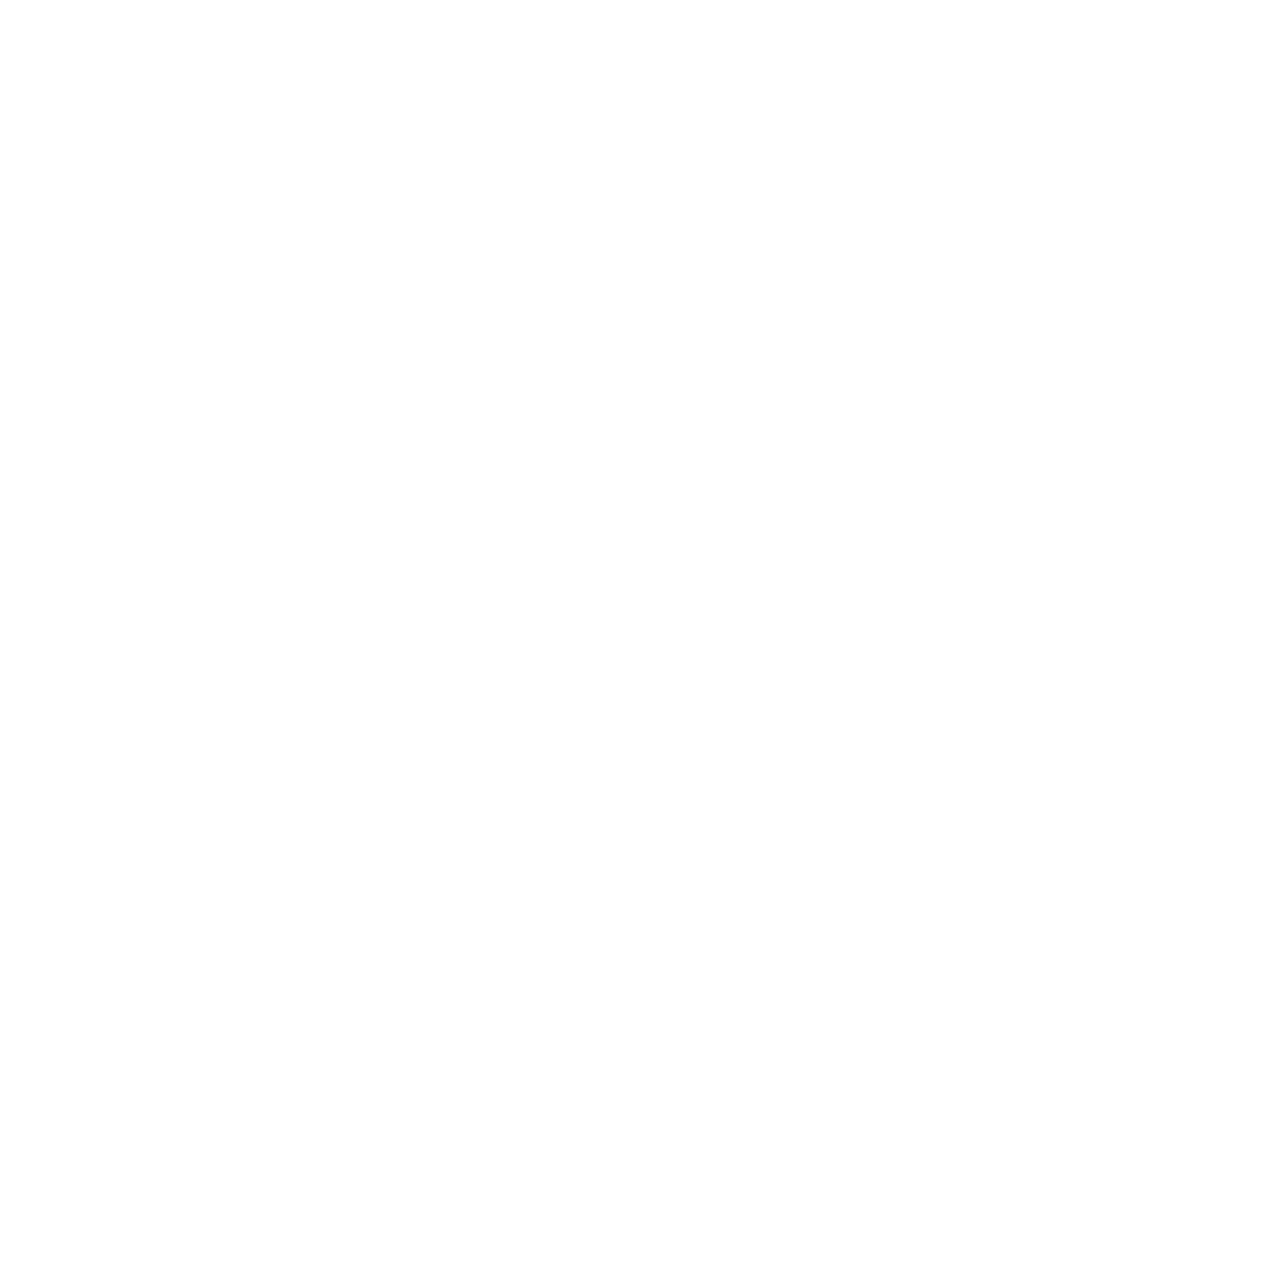

In [27]:
%matplotlib agg
medians = np.median(sample, axis=0)
corner.corner(sample, labels=[C.labels_c[i] for i in indexes], quantiles=[0.01, 0.99], truths=medians, show_titles=True)
plt.suptitle(r'$\nu_f=%.2f$, $\nu_1=%.2f$, $\nu_2=%.2f$, $D=%.1f$, $R_\mathrm{wall}=%s$, $R_\mathrm{fil}=%s$' % (nuf, nu1, nu2, D, Rwall, Rfil))
plt.savefig('/tmp/corner.pdf')
%matplotlib nbagg

# Probability of the constrains ?

Use this to restore from the disk

In [5]:
f = np.load('covariance.npz')
cov, D, R, Rpts, Npts = f['cov'], f['D'], f['R'], f['Rpts'], f['Npts']
C = Correlator(D=D, R=R, Rpts=Rpts, Npts=Npts)
C._covariance = cov

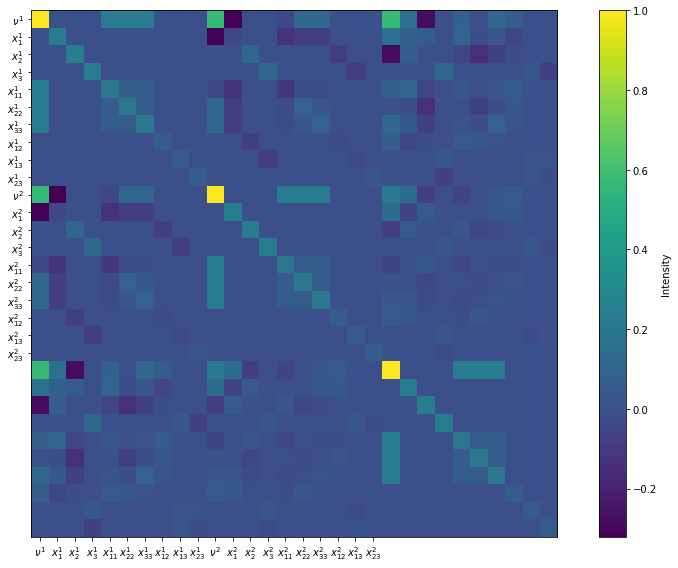

In [10]:
plt.imshow(cov[:30, :30])
C = plt.colorbar()
C.set_label('Intensity')

ticks = list(range(20))
tick_labels = [r'\nu', 'x_1', 'x_2', 'x_3', 'x_{11}', 'x_{22}', 'x_{33}', 'x_{12}', 'x_{13}', 'x_{23}'] * 2
plt.xticks(ticks, ['$%s^%s$' % (s, 1 if i < 10 else 2) for (i, s) in enumerate(tick_labels)])
_ = plt.yticks(ticks, ['$%s^%s$' % (s, 1 if i < 10 else 2) for (i, s) in enumerate(tick_labels)])

plt.tight_layout()
plt.savefig('covariance.pdf')

In [42]:
mean = np.zeros(34)
cov = cov
cons = np.zeros_like(mean) * np.nan

# Impose zero gradient
cons[[1, 2, 3, 11, 12, 13, 21, 22, 23, 31, 32, 33]] = 0
# Impose heigth of center
cons[30] = 1.68

mean_c, cov_c = constrain(mean, cov[:34, :34], cons)

In [12]:
np.random.seed(16091992)
sample = np.random.multivariate_normal(mean_c, cov_c, 5000000)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


In [13]:
# Indexes of the matrix element
mapping = np.array([[1, 4, 5], 
                    [4, 2, 6], 
                    [5, 6, 3]])

# Compute the eigenvalues of the three points
hij1 = np.linalg.eigvalsh(sample[:, mapping   ])
hij2 = np.linalg.eigvalsh(sample[:, mapping+ 7])
hij3 = np.linalg.eigvalsh(sample[:, mapping+14])
# TODO quick draws where the height is inversed by swapping them
mask = (np.sum(hij1 < 0, axis=1) == 2) & (np.sum(hij2 < 0, axis=1) == 2) & (np.sum(hij3 < 0, axis=1) == 2) & (sample[:, 0] >= sample[:, 7]) & (sample[:, 7] >= sample[:, 14]) 
print('%s samples (%.3f%%)' % (mask.sum(), mask.sum() / len(mask)))

96239 samples (0.019%)


In [14]:
hij = np.concatenate((hij1[mask].T, hij2[mask].T, hij3[mask].T)).T
weights = np.product(hij, axis=1)

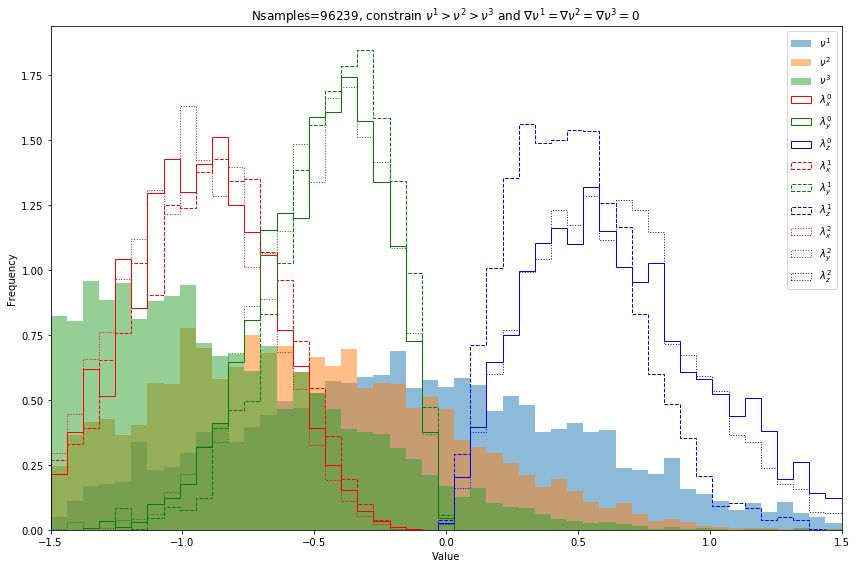

In [23]:
from cycler import cycler

bins = np.linspace(-1.5, 1.5, 50)
kwa = dict(bins=bins, normed=True, alpha=0.5, weights=weights, histtype='stepfilled')
plt.hist(sample[mask, 0], label=r'$\nu^1$', **kwa)
plt.hist(sample[mask, 7], label=r'$\nu^2$', **kwa)
plt.hist(sample[mask, 14], label=r'$\nu^3$', **kwa)

cs = cycler(ls=('solid','dashed', 'dotted')) * cycler(color=('red', 'green', 'blue'))

for i, style in enumerate(cs):
    ii = i // 3
    kwa = dict(bins=bins, histtype='step', normed=True, weights=weights)
    plt.hist(hij[:, i], label='$\lambda^{%s}_%s$' % (ii, 'xyz'[i % 3]),
             **kwa, **style)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(bins.min(), bins.max())
plt.title(r'Nsamples=%s, constrain $\nu^1 > \nu^2 > \nu^3$ and $\nabla \nu^1 = \nabla \nu^2 = \nabla \nu^3 = 0 $ ' % (mask.sum()))
plt.tight_layout()
plt.savefig('distribution_eigvals.pdf', format='pdf')

In [24]:
np.round([sample[mask, 0].mean(), sample[mask, 7].mean(), sample[mask, 14].mean()], 3)

array([ 0.074, -0.374, -0.886])

In [18]:
from corner import corner

In [26]:
hij.shape

(96239, 9)

In [35]:
sampleplot = np.concatenate([[sample[mask, 0], sample[mask, 7], sample[mask, 14]], hij.T]).T
sampleplot.shape

(96239, 12)

In [ ]:
N = 12
labels = [r'$%s$' % e for e in r'\nu^1 \nu^2 \nu^3 h^1_{xx} h^1_{yy} h^1_{zz} h^2_{xx} h^2_{yy} h^2_{zz} h^3_{xx} h^3_{yy} h^3_{zz}'.split()][:N]
foo = corner(sample[mask, :N], bins=20, weights=weights, quantiles=[0.05, 0.5, 0.95], labels=labels)

plt.savefig('corner.pdf')

## Constrained to $\nabla \nu=0$

Use this to restore from the disk

In [281]:
f = np.load('covariance.npz')
cov, D, R, Rpts, Npts = f['cov'], f['D'], f['R'], f['Rpts'], f['Npts']
C = Correlator(D=D, R=R, Rpts=Rpts, Npts=Npts)
C._covariance = cov

In [282]:
mean_c, cov_c = C.constrain(delta_center=1.68, delta_peaks=[0.074, -0.373, -0.887])

Text(0,0.5,'$\\nu$')

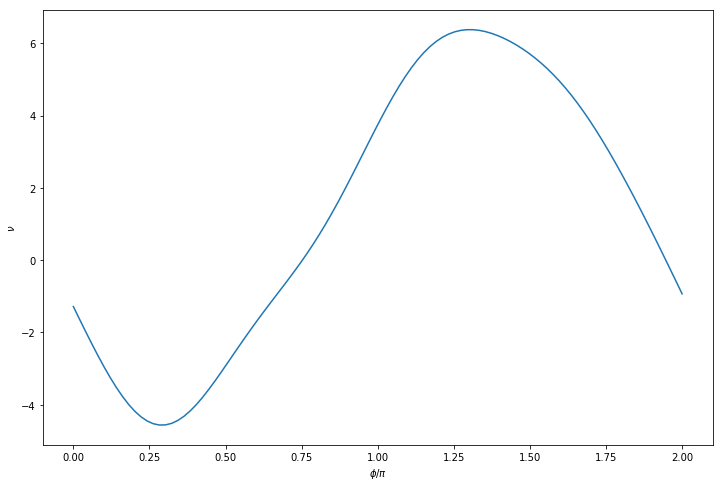

In [292]:
plt.plot(np.linspace(0, 2, 100), mean_c[-100:])
plt.xlabel('$\phi/\pi$')
plt.ylabel(r'$\nu$')

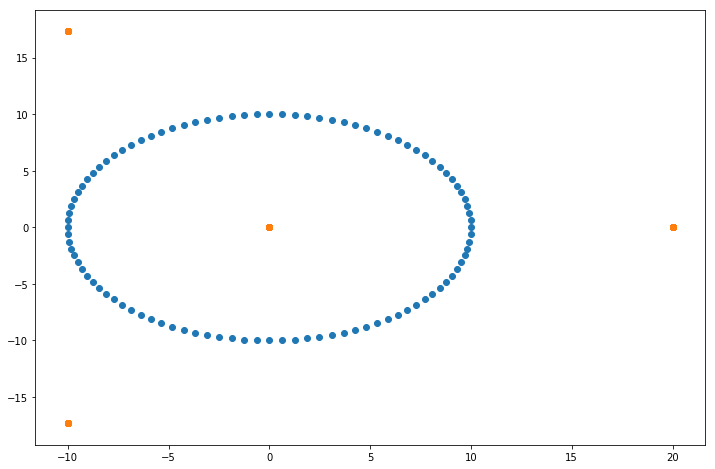

In [289]:
C.plot()

# TODO:
- compute correlation in $(u_r, u_\theta, u_z)$ instead of $(u_x, u_y, u_z)$
- impose orientation of hessian $e_1 = u_r, e_2 = u_\theta, e_3 = u_z$ and $\lambda_1 \leq \lambda_2 \leq 0 \leq \lambda_3$.